In [ ]:
!pip install scipy scikit-image matplotlib pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from skimage.transform import radon
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt

In [ ]:
from scipy.io import loadmat
import numpy as np

# Load Affine MNIST
dataset_path = "/content/10.mat"
data = loadmat(dataset_path)
images = data['affNISTdata']['image'][0][0].reshape(40, 40, 50000)
labels = data['affNISTdata']['label_int'][0][0]

# Normalize and reshape
images = np.moveaxis(images, -1, 0) / 255.0  # Shape: (50000, 40, 40)
labels = labels.flatten()  # Shape: (50000,)


In [ ]:
!pip install pytranskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
from pytranskit.classification.rcdt_ns import RCDT_NS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define RCDT-NS instance
rcdt_ns = RCDT_NS(num_classes=10, rm_edge=True)

# Define Radon transform angles
theta = np.linspace(0, 176, 45)  # Adjust angles as needed

# Apply RCDT-NS to train and test sets
X_train_rcdt = rcdt_ns.fun_rcdt_batch(X_train)  # Pass only the dataset
X_test_rcdt = rcdt_ns.fun_rcdt_batch(X_test)

In [ ]:
# Train Nearest Subspace Classifier
rcdt_ns.fit(X_train_rcdt, y_train)


Calculating RCDTs for training images ...
Generating basis vectors for each class ...


In [ ]:
# Predict and evaluate
y_pred = rcdt_ns.predict(X_test_rcdt)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Calculating RCDTs for testing images ...
Finding nearest subspace for each test sample ...
Test Accuracy: 64.09%


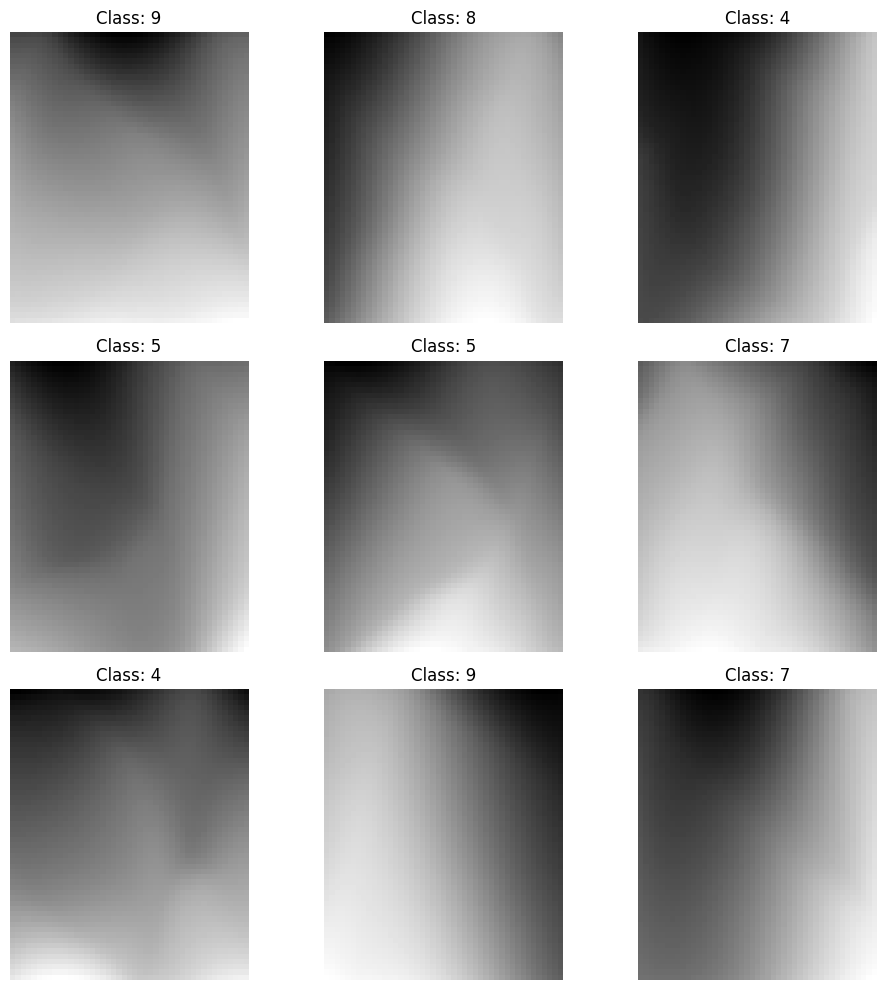

In [ ]:
import matplotlib.pyplot as plt

# Function to display transformed images
def show_transformed_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')  # Display as grayscale
        # Check if the label is within the range of class_names
        label_index = labels[i]
        if 0 <= label_index < len(class_names):
            plt.title(f"Class: {class_names[label_index]}")
        else:
            plt.title(f"Class: {label_index} (Unknown)")  # Handle out-of-range labels
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming your labels are in the range 0-9 for MNIST:
class_names = [str(i) for i in range(10)]  # Create class names for 0-9
show_transformed_images(X_train_rcdt, y_train, class_names)

Total misclassified images: 3591


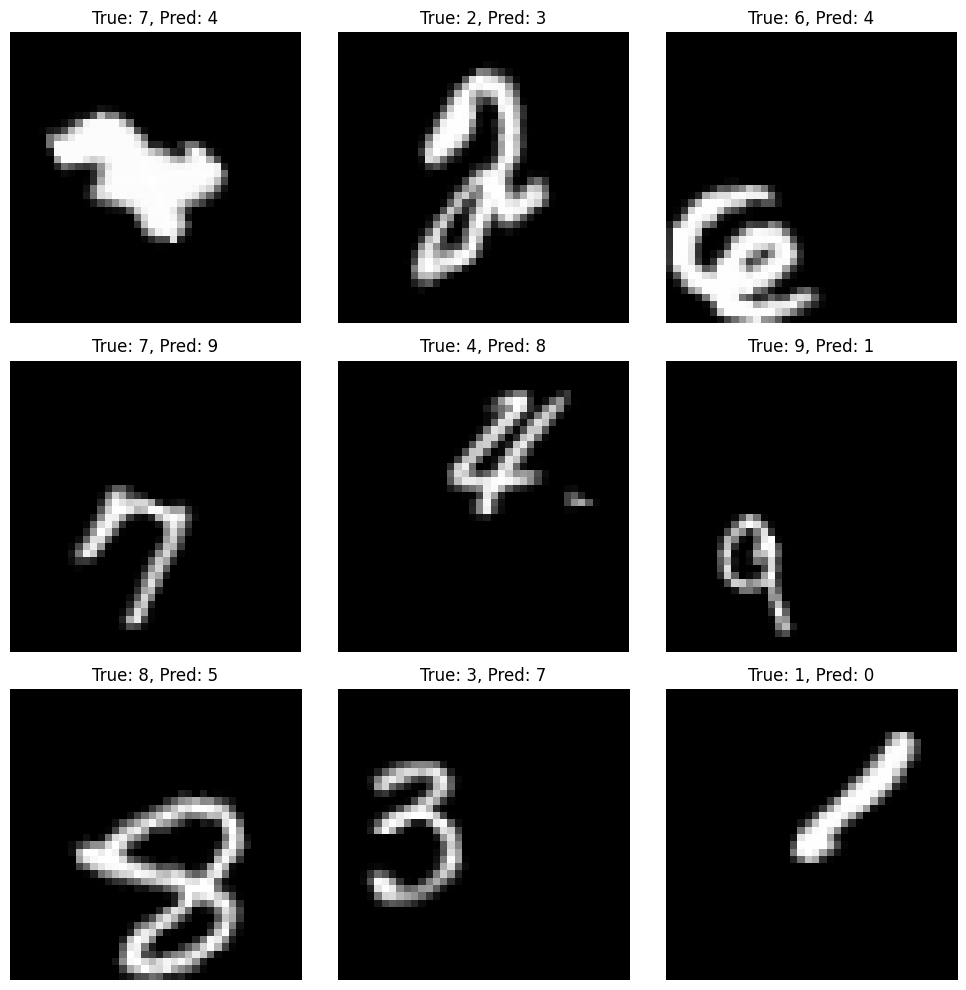

In [ ]:
# Visualize Some Misclassified Samples
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Total misclassified images: {len(misclassified_indices)}")

plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image

# Define a directory to save transformed images
save_dir = '/content/drive/MyDrive/RCDT_Images'
os.makedirs(save_dir, exist_ok=True)

# Save the transformed images as NumPy arrays
np.save(os.path.join(save_dir, 'X_train_rcdt.npy'), X_train_rcdt)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)

# Alternatively, save a few as PNG images
for i in range(10):  # Save first 10 images
    img = Image.fromarray((X_train_rcdt[i] * 255).astype(np.uint8))  # Scale back to 0-255
    img.save(os.path.join(save_dir, f'rcdt_image_{i}.png'))


In [ ]:
rcdt_images = np.load('/content/drive/MyDrive/RCDT_Images/X_train_rcdt.npy')
rcdt_y = np.load('/content/drive/MyDrive/RCDT_Images/y_train.npy')

In [ ]:
# Ensure transformed images are reshaped for CNN
X_train_rcdt = X_train_rcdt.reshape(-1, X_train_rcdt.shape[1], X_train_rcdt.shape[2], 1)  # Add channel dimension
X_test_rcdt = X_test_rcdt.reshape(-1, X_test_rcdt.shape[1], X_test_rcdt.shape[2], 1)

# Check shapes
print(f"X_train shape: {X_train_rcdt.shape}, X_test shape: {X_test_rcdt.shape}")


X_train shape: (40000, 55, 45, 1), X_test shape: (10000, 55, 45, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_rcdt.shape[1], X_train_rcdt.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Change to the number of classes in your dataset
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
batch_size = 32
epochs = 10

history = model.fit(X_train_rcdt, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)


Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 150s 132ms/step - accuracy: 0.1069 - loss: 2.3029 - val_accuracy: 0.1198 - val_loss: 2.3004
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 190s 122ms/step - accuracy: 0.1119 - loss: 2.3016 - val_accuracy: 0.1198 - val_loss: 2.2998
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 141s 120ms/step - accuracy: 0.1106 - loss: 2.3015 - val_accuracy: 0.1198 - val_loss: 2.3000
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 133s 119ms/step - accuracy: 0.1076 - loss: 2.3017 - val_accuracy: 0.1198 - val_loss: 2.3002
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 140s 117ms/step - accuracy: 0.1060 - loss: 2.3019 - val_accuracy: 0.1198 - val_loss: 2.2996
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 131s 117ms/step - accuracy: 0.1125 - loss: 2.3015 - val_accuracy: 0.1198 - val_loss: 2.3000
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 133s 119ms/step - accuracy: 0.1099 - loss: 2.3018 - val_accuracy: 0.1198 - val_loss: 2.3000
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 118ms/step - ac

In [ ]:
test_loss, test_acc = model.evaluate(X_test_rcdt, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.1127 - loss: 2.3006
Test accuracy: 11.35%


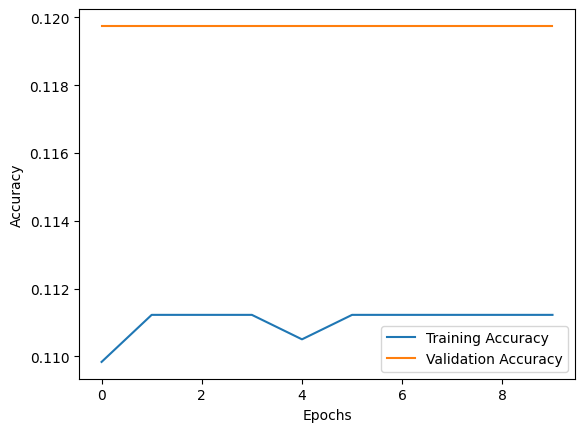

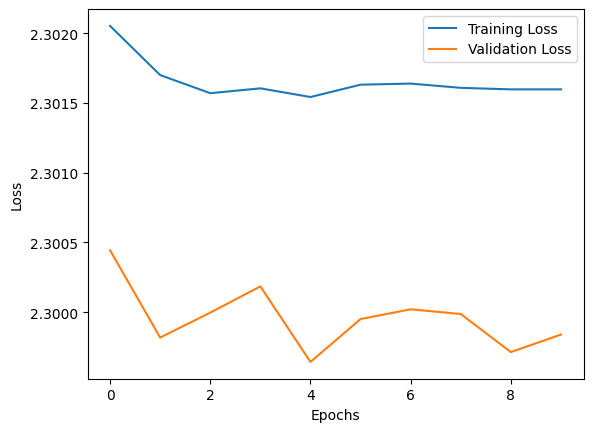

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Flatten the RCDT-transformed images for SVM
X_train_flat = X_train_rcdt.reshape(X_train_rcdt.shape[0], -1)  # Flatten to (n_samples, n_features)
X_test_flat = X_test_rcdt.reshape(X_test_rcdt.shape[0], -1)

# Check shapes
print(f"X_train_flat shape: {X_train_flat.shape}, X_test_flat shape: {X_test_flat.shape}")


X_train_flat shape: (40000, 2475), X_test_flat shape: (10000, 2475)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM with an appropriate kernel (linear, rbf, etc.)
svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Train the SVM model
svm_model.fit(X_train_flat, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test_flat)


In [ ]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with SVM: {accuracy * 100:.2f}%")


Test Accuracy with SVM: 85.58%


Total misclassified images: 1442


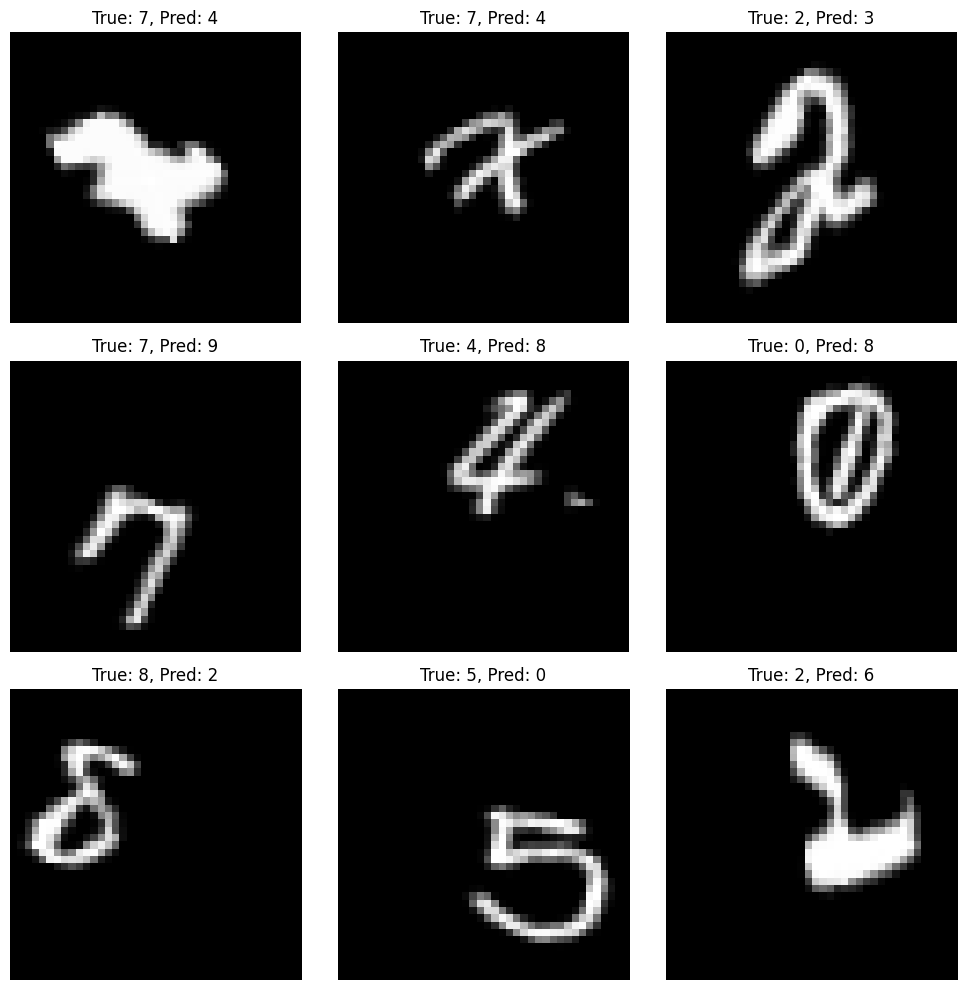

In [ ]:
# Visualize Some Misclassified Samples
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Total misclassified images: {len(misclassified_indices)}")

plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()